In [1]:
import pandas as pd
import numpy as numpy
import json 
import os 
import pylab as pl
import urllib
import requests
import geopandas as gp
import fiona
import shapely
from fiona.crs import from_epsg
import os
import pandas as pd
import urllib
import requests
import json
import sys
import io
import shapely
import base64
import urllib.request
import functools
import geopandas as gp
import fiona
import numpy as np
import datetime


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## get gentrification indication data

In [2]:
path = '/Users/katharinevoorhees/Downloads/ACS_14_5YR_S1501/ACS_14_5YR_S1501_with_ann.csv'

fourteen = pd.read_csv(path, skiprows=1)

fourteen.rename(columns={"Total; Estimate; Percent bachelor's degree or higher":'%higher_ed_14',
                "Total; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2014 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings":
                          'median_earnings_14'}, inplace=True)
fourteen = fourteen[['Id2', 'Geography', '%higher_ed_14','median_earnings_14']]
fourteen.head()

,Id2,Geography,%higher_ed_14,median_earnings_14
0,36001000100,"Census Tract 1, Albany County, New York",14.9,23974
1,36001000200,"Census Tract 2, Albany County, New York",10.2,31368
2,36001000300,"Census Tract 3, Albany County, New York",26.8,36024
3,36001000401,"Census Tract 4.01, Albany County, New York",43.9,49909
4,36001000403,"Census Tract 4.03, Albany County, New York",58.4,49840


In [3]:
path = '/Users/katharinevoorhees/Downloads/ACS_09_5YR_S1501/ACS_09_5YR_S1501_with_ann.csv'

ohnine = pd.read_csv(path, skiprows=1)

ohnine.rename(columns={"Total; Estimate; Population 25 years and over - Percent bachelor's degree or higher":'%higher_ed_09',
                "Total; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2009 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings":
                          'median_earnings_09'}, inplace=True)
ohnine = ohnine[['Id2', 'Geography', '%higher_ed_09','median_earnings_09']]
ohnine.head()

,Id2,Geography,%higher_ed_09,median_earnings_09
0,36001000100,"Census Tract 1, Albany County, New York",11.0,35552
1,36001000200,"Census Tract 2, Albany County, New York",17.0,26051
2,36001000300,"Census Tract 3, Albany County, New York",22.7,33833
3,36001000401,"Census Tract 4.01, Albany County, New York",39.3,58869
4,36001000403,"Census Tract 4.03, Albany County, New York",51.5,45000


In [4]:
data = fourteen.merge(ohnine, on='Id2')
data.drop(columns=['Geography_y'], inplace=True)


In [5]:
data['%higher_ed_14'].replace('-',np.nan,inplace=True)
data['%higher_ed_09'].replace('-',np.nan,inplace=True)
data['median_earnings_14'].replace('-',np.nan,inplace=True)
data['median_earnings_09'].replace('-',np.nan,inplace=True)
data['median_earnings_09'].replace('2,500-',np.nan,inplace=True)



data.dropna(inplace=True)

data['%higher_ed_14'] = data['%higher_ed_14'].astype('float')
data['%higher_ed_09'] = data['%higher_ed_09'].astype('float')
data['median_earnings_14'] = data['median_earnings_14'].astype('float')
data['median_earnings_09'] = data['median_earnings_09'].astype('float')


data.sort_values('%higher_ed_14',ascending=False).head()

,Id2,Geography_x,%higher_ed_14,median_earnings_14,%higher_ed_09,median_earnings_09
3883,36109000400,"Census Tract 4, Tompkins County, New York",93.1,30737.0,63.5,22083.0
2226,36061020701,"Census Tract 207.01, New York County, New York",91.4,38902.0,87.0,34298.0
2038,36061002100,"Census Tract 21, New York County, New York",89.9,142148.0,83.4,130304.0
2052,36061003300,"Census Tract 33, New York County, New York",89.8,104199.0,87.3,101623.0
826,36047000700,"Census Tract 7, Kings County, New York",89.6,80747.0,78.4,80032.0


In [6]:
len(data['median_earnings_09'])

4146

In [7]:
data['%higher_ed_increase'] = data['%higher_ed_14'] - data['%higher_ed_09']
data['earnings_dif'] = data['median_earnings_14']-data['median_earnings_09']
data['%earnings_change'] = ((data['earnings_dif']/data['median_earnings_09'])*100)
data.head()

,Id2,Geography_x,%higher_ed_14,median_earnings_14,%higher_ed_09,median_earnings_09,%higher_ed_increase,earnings_dif,%earnings_change
0,36001000100,"Census Tract 1, Albany County, New York",14.9,23974.0,11.0,35552.0,3.9,-11578.0,-32.566382
1,36001000200,"Census Tract 2, Albany County, New York",10.2,31368.0,17.0,26051.0,-6.8,5317.0,20.409965
2,36001000300,"Census Tract 3, Albany County, New York",26.8,36024.0,22.7,33833.0,4.1,2191.0,6.475926
3,36001000401,"Census Tract 4.01, Albany County, New York",43.9,49909.0,39.3,58869.0,4.6,-8960.0,-15.220235
4,36001000403,"Census Tract 4.03, Albany County, New York",58.4,49840.0,51.5,45000.0,6.9,4840.0,10.755556


In [8]:
path = '/Users/katharinevoorhees/Downloads/ACS_14_5YR_B25077/ACS_14_5YR_B25077_with_ann.csv'

home14 = pd.read_csv(path, skiprows=1)

home14 = home14[['Id2','Estimate; Median value (dollars)']]
home14.rename(columns={'Estimate; Median value (dollars)':
                       'med_home_val_14'}, inplace=True)

home14.head()

,Id2,med_home_val_14
0,36001000100,94500
1,36001000200,85200
2,36001000300,175900
3,36001000401,154200
4,36001000403,193400


In [9]:
path = '/Users/katharinevoorhees/Downloads/ACS_09_5YR_B25077/ACS_09_5YR_B25077_with_ann.csv'

home09 = pd.read_csv(path, skiprows=1)

home09 = home09[['Id2','Estimate; Median value (dollars)']]
home09.rename(columns={'Estimate; Median value (dollars)':
                       'med_home_val_09'}, inplace=True)
home09.head()

,Id2,med_home_val_09
0,36001000100,112700
1,36001000200,131800
2,36001000300,127300
3,36001000401,163600
4,36001000403,203100


In [10]:
home_data = home09.merge(home14,on='Id2')
home_data.head()

,Id2,med_home_val_09,med_home_val_14
0,36001000100,112700,94500
1,36001000200,131800,85200
2,36001000300,127300,175900
3,36001000401,163600,154200
4,36001000403,203100,193400


In [11]:
home_data['med_home_val_09'].replace('1,000,000+',1000000,inplace=True)
home_data['med_home_val_14'].replace('1,000,000+',1000000,inplace=True)
home_data['med_home_val_09'].replace('-',np.nan, inplace=True)
home_data['med_home_val_14'].replace('-',np.nan, inplace=True)


home_data['med_home_val_09'] = home_data['med_home_val_09'].astype('float')
home_data['med_home_val_14'] = home_data['med_home_val_14'].astype('float')

In [12]:
home_data.dropna(inplace=True)
home_data['%home_increase'] = np.round(((home_data['med_home_val_14']-home_data['med_home_val_09'])/\
                               home_data['med_home_val_09'])*100,1)
home_data.head()

,Id2,med_home_val_09,med_home_val_14,%home_increase
0,36001000100,112700.0,94500.0,-16.1
1,36001000200,131800.0,85200.0,-35.4
2,36001000300,127300.0,175900.0,38.2
3,36001000401,163600.0,154200.0,-5.7
4,36001000403,203100.0,193400.0,-4.8


In [13]:
home_data.describe()

,Id2,med_home_val_09,med_home_val_14,%home_increase
count,4.003000e+03,4003.000000,4003.000000,4003.000000
mean,3.606350e+10,384319.985011,378586.734949,3.722833
std,3.089320e+07,244398.181959,242443.350615,47.513985
min,3.600100e+10,12600.000000,14900.000000,-90.800000
25%,3.604703e+10,143850.000000,155450.000000,-9.900000
50%,3.606101e+10,397600.000000,368000.000000,0.000000
75%,3.608112e+10,548500.000000,520300.000000,10.550000
max,3.611902e+10,1000000.000000,1000000.000000,1837.800000


In [14]:
path = '/Users/katharinevoorhees/Downloads/ACS_14_5YR_B02001/ACS_14_5YR_B02001_with_ann.csv'

race14 = pd.read_csv(path, skiprows=1)

race14 = race14.rename(columns={"Estimate; Total:":'tot14',
               'Estimate; Total: - White alone' :'wh14'})
race14['%white_14'] = (race14['wh14']/race14['tot14'])*100
race14 = race14[['Id2','wh14', '%white_14']]
race14.head()

,Id2,wh14,%white_14
0,36001000100,733,33.303044
1,36001000200,530,10.196229
2,36001000300,2503,45.352419
3,36001000401,2092,88.381918
4,36001000403,3249,70.969856


In [15]:
path = '/Users/katharinevoorhees/Downloads/ACS_09_5YR_B02001/ACS_09_5YR_B02001_with_ann.csv'

race09 = pd.read_csv(path, skiprows=1)

race09 = race09.rename(columns={"Estimate; Total:":'tot09',
               'Estimate; White alone' :'wh09'})
race09['%white_09'] = (race09['wh09']/race09['tot09'])*100
race09 = race09[['Id2','wh09', '%white_09']]
race09.head()

,Id2,wh09,%white_09
0,36001000100,700,32.543003
1,36001000200,602,11.982484
2,36001000300,3594,58.610568
3,36001000401,2025,92.677346
4,36001000403,3362,77.180900


In [16]:
race_data = race09.merge(race14, on='Id2')

race_data['%increase_white'] = race_data['%white_14'] - race_data['%white_09']

race_data.head()

,Id2,wh09,%white_09,wh14,%white_14,%increase_white
0,36001000100,700,32.543003,733,33.303044,0.760041
1,36001000200,602,11.982484,530,10.196229,-1.786255
2,36001000300,3594,58.610568,2503,45.352419,-13.258149
3,36001000401,2025,92.677346,2092,88.381918,-4.295427
4,36001000403,3362,77.180900,3249,70.969856,-6.211044


In [17]:
data = data.merge(home_data, how='left', on='Id2')
data = data.merge(race_data, how='left', on='Id2')

data = data[['Id2','%higher_ed_increase','%home_increase','%increase_white',"%earnings_change"]]

data.head()

,Id2,%higher_ed_increase,%home_increase,%increase_white,%earnings_change
0,36001000100,3.9,-16.1,0.760041,-32.566382
1,36001000200,-6.8,-35.4,-1.786255,20.409965
2,36001000300,4.1,38.2,-13.258149,6.475926
3,36001000401,4.6,-5.7,-4.295427,-15.220235
4,36001000403,6.9,-4.8,-6.211044,10.755556


In [18]:
path= '/Users/katharinevoorhees/patrol_allocation/tract_precinct_key.csv'
prec_key = pd.read_csv(path)
prec_key = prec_key[['precinct','tractid']]
prec_key.head(3)

,precinct,tractid
0,1.0,36061004700
1,1.0,36061004900
2,1.0,36061003700


In [19]:
acs_data = prec_key.merge(data, left_on='tractid', right_on='Id2')
acs_data.head()

,precinct,tractid,Id2,%higher_ed_increase,%home_increase,%increase_white,%earnings_change
0,1.0,36061004700,36061004700,6.5,0.0,-3.396385,-3.584302
1,1.0,36061004900,36061004900,-2.0,0.0,0.946872,19.012517
2,1.0,36061000900,36061000900,-7.1,55.1,18.743693,37.132999
3,1.0,36061000700,36061000700,1.8,-8.9,6.428272,-12.865166
4,1.0,36061001300,36061001300,2.9,-4.1,7.838132,13.498200


In [20]:
acs_data.shape

(1881, 7)

In [21]:
prec_key.shape

(2167, 2)

In [22]:
acs_data_grouped = acs_data.groupby('precinct').mean().reset_index()

acs_data_grouped.head()

,precinct,tractid,Id2,%higher_ed_increase,%home_increase,%increase_white,%earnings_change
0,1.0,3.606100e+10,3.606100e+10,2.960000,7.870000,0.457466,15.936095
1,5.0,3.606100e+10,3.606100e+10,6.854545,7.030000,4.543218,31.588472
2,6.0,3.606101e+10,3.606101e+10,1.391667,3.558333,-1.624774,15.786130
3,7.0,3.606100e+10,3.606100e+10,0.650000,5.612500,-1.897496,11.932918
4,9.0,3.606100e+10,3.606100e+10,4.413333,1.200000,-2.739962,27.541365


In [23]:
### ***add 311 noise  complaints

In [24]:
url = 'https://data.cityofnewyork.us/api/views/p5f6-bkga/rows.csv?accessType=DOWNLOAD'
complaint = pd.read_csv(url)
complaint.head()

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,31997716,11/16/2015 11:04:21 PM,11/16/2015 11:13:31 PM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10002.0,303 BROOME STREET,BROOME STREET,ELDRIDGE STREET,FORSYTH STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,11/17/2015 07:04:21 AM,The Police Department responded to the complai...,11/16/2015 11:13:31 PM,03 MANHATTAN,MANHATTAN,986399.0,201129.0,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.718729,-73.992248,"(40.71872911078678, -73.99224755670346)"
1,31997717,11/16/2015 12:44:27 PM,11/16/2015 03:30:19 PM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,11206.0,89 MOORE STREET,MOORE STREET,GRAHAM AVENUE,HUMBOLDT STREET,NaN,NaN,ADDRESS,BROOKLYN,NaN,Precinct,Closed,11/16/2015 08:44:27 PM,The Police Department responded to the complai...,11/16/2015 03:30:19 PM,01 BROOKLYN,BROOKLYN,1000311.0,195702.0,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.703819,-73.942073,"(40.70381897093329, -73.94207345177706)"
2,31997718,11/16/2015 11:28:20 PM,11/17/2015 01:47:37 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,10035.0,209 EAST 118 STREET,EAST 118 STREET,3 AVENUE,2 AVENUE,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,11/17/2015 07:28:20 AM,The Police Department responded to the complai...,11/17/2015 01:47:38 AM,11 MANHATTAN,MANHATTAN,1001254.0,230405.0,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.799068,-73.938585,"(40.79906813374288, -73.93858462118362)"
3,31997719,11/16/2015 06:27:05 PM,11/16/2015 08:04:57 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,10002.0,60 PITT STREET,PITT STREET,DELANCEY STREET,RIVINGTON STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,11/17/2015 02:27:05 AM,The Police Department reviewed your complaint ...,11/16/2015 08:04:58 PM,03 MANHATTAN,MANHATTAN,989045.0,200817.0,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.717872,-73.982702,"(40.71787170731287, -73.9827024255027)"
4,31997723,11/16/2015 05:20:00 PM,11/17/2015 11:54:00 AM,DEP,Department of Environmental Protection,Noise,"Noise, Barking Dog (NR5)",NaN,11221.0,600 GATES AVENUE,GATES AVENUE,THROOP AVE,MARCUS GARVEY BLVD,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,NaN,The Department of Environmental Protection det...,11/17/2015 11:54:00 AM,03 BROOKLYN,BROOKLYN,1000631.0,189691.0,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.687320,-73.940934,"(40.687319588404215, -73.94093393966676)"


In [25]:
complaint['Created Date'] = pd.to_datetime(complaint['Created Date'])

In [26]:
complaint['year'] = complaint['Created Date'].dt.year
complaint.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,year
0,31997716,2015-11-16 23:04:21,11/16/2015 11:13:31 PM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10002.0,303 BROOME STREET,BROOME STREET,ELDRIDGE STREET,FORSYTH STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,11/17/2015 07:04:21 AM,The Police Department responded to the complai...,11/16/2015 11:13:31 PM,03 MANHATTAN,MANHATTAN,986399.0,201129.0,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.718729,-73.992248,"(40.71872911078678, -73.99224755670346)",2015
1,31997717,2015-11-16 12:44:27,11/16/2015 03:30:19 PM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,11206.0,89 MOORE STREET,MOORE STREET,GRAHAM AVENUE,HUMBOLDT STREET,NaN,NaN,ADDRESS,BROOKLYN,NaN,Precinct,Closed,11/16/2015 08:44:27 PM,The Police Department responded to the complai...,11/16/2015 03:30:19 PM,01 BROOKLYN,BROOKLYN,1000311.0,195702.0,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.703819,-73.942073,"(40.70381897093329, -73.94207345177706)",2015


In [27]:
complaint['lonlat'] = list(zip(complaint.Longitude, complaint.Latitude))

In [28]:
complaint['geometry'] = complaint[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [29]:
complaint_map = gp.GeoDataFrame(complaint)

In [30]:
complaint_map.crs  = from_epsg(4326)

In [31]:
complaint_map.to_crs(epsg=2263, inplace=True)

In [32]:
#complaint_map.plot();

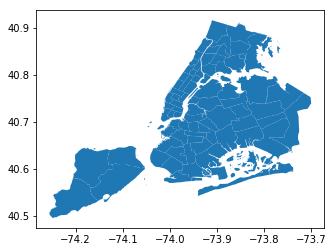

In [33]:
url = 'https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile'
precinct = gp.GeoDataFrame.from_file(url)
precinct.plot();

In [34]:
precinct.to_crs(epsg=2263, inplace=True)

In [35]:
complaints_joined = gp.sjoin(precinct,complaint_map, how='right')

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2048: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [36]:
complaints_joined.head()

,index_left,precinct,shape_area,shape_leng,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,year,lonlat,geometry
index_right,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1505879,0.0,1.0,4.730176e+07,80586.154615,23859767,2012-08-23 09:14:39,08/23/2012 10:04:11 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10013.0,NaN,NaN,NaN,NaN,WEST STREET,WATTS STREET,INTERSECTION,NEW YORK,NaN,Precinct,Closed,08/23/2012 05:14:39 PM,The Police Department responded to the complai...,08/23/2012 10:04:11 AM,01 MANHATTAN,MANHATTAN,981103.0,203150.0,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.724276,-74.011354,"(40.72427596907589, -74.0113536387619)",2012,"(-74.0113536387619, 40.72427596907589)",POINT (981103.0000018629 203150.0144043296)
1318399,0.0,1.0,4.730176e+07,80586.154615,21497582,2011-09-22 20:33:00,10/03/2011 06:30:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10013.0,457 WASHINGTON STREET,WASHINGTON STREET,WATTS STREET,CANAL STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,NaN,The Department of Environmental Protection did...,10/03/2011 06:30:00 AM,01 MANHATTAN,MANHATTAN,981425.0,203158.0,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.724298,-74.010192,"(40.72429803582802, -74.01019194156503)",2011,"(-74.01019194156503, 40.72429803582802)",POINT (981425.0000016782 203158.0144043406)
1922346,0.0,1.0,4.730176e+07,80586.154615,37722785,2017-11-17 23:23:00,11/28/2017 12:15:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10013.0,456 WASHINGTON STREET,WASHINGTON STREET,WATTS ST,CANAL ST,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,NaN,The Department of Environmental Protection did...,11/28/2017 12:15:00 AM,01 MANHATTAN,MANHATTAN,981419.0,203159.0,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.724301,-74.010214,"(40.72430077866735, -74.01021358858705)",2017,"(-74.01021358858705, 40.72430077866735)",POINT (981419.0000016782 203159.0144043338)
1170471,0.0,1.0,4.730176e+07,80586.154615,19515258,2011-01-03 16:52:14,01/03/2011 07:07:31 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,10013.0,459 WASHINGTON STREET,WASHINGTON STREET,WATTS STREET,CANAL STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,01/04/2011 12:52:14 AM,The Police Department responded to the complai...,01/03/2011 07:07:31 PM,01 MANHATTAN,MANHATTAN,981429.0,203183.0,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.724367,-74.010178,"(40.724366656041894, -74.01017752097671)",2011,"(-74.01017752097671, 40.72436665604189)",POINT (981429.0000016722 203183.0144043528)
1222170,0.0,1.0,4.730176e+07,80586.154615,20248635,2011-04-16 08:22:22,04/16/2011 08:36:42 AM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,10013.0,459 WASHINGTON STREET,WASHINGTON STREET,WATTS STREET,CANAL STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,04/16/2011 04:22:22 PM,The Police Department responded to the complai...,04/16/2011 08:36:42 AM,01 MANHATTAN,MANHATTAN,981429.0,203183.0,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.724367,-74.010178,"(40.724366656041894, -74.01017752097671)",2011,"(-74.01017752097671, 40.72436665604189)",POINT (981429.0000016722 203183.0144043528)


In [ ]:
grouped_complaints = complaints_joined.groupby(['precinct','year']).count().reset_index()
complaint_2010 = grouped_complaints[grouped_complaints['year'] == 2010] 
complaint_2014 = grouped_complaints[grouped_complaints['year'] == 2014]
complaint_2010.rename(columns={'index_left':'count_10'},inplace=True)
complaint_2014.rename(columns={'index_left':'count_14'},inplace=True)
complaint_data = complaint_2010.merge(complaint_2014, on='precinct')
complaint_data = complaint_data[['precinct','count_10','count_14']]
complaint_data.head()

In [ ]:
complaint_data.to_csv('noise_complaints_aggregated.csv')

In [ ]:
complaint_data['%change_noise'] = ((complaint_data['count_14'] - complaint_data['count_10'])/\
                                complaint_data['count_10'])*100

complaint_data.describe()

## get gentrification score

In [ ]:
gent = complaint_data.merge(acs_data_grouped,on='precinct')
gent.head()

In [ ]:
gent['city_noise'] = gent['%change_noise']/gent['%change_noise'].sum()
gent['city_edu'] = gent['%higher_ed_increase']/gent['%higher_ed_increase'].sum()
gent['city_home'] = gent['%home_increase']/gent['%home_increase'].sum()
gent['city_white'] = gent['%increase_white']/gent['%increase_white'].sum()
gent['city_earnings'] = gent['%earnings_change']/gent['%earnings_change'].sum()
gent.head()

In [ ]:
#gent['city_noise']

gent['gent_total'] = gent['city_noise']+gent['city_edu']+gent['city_home']+gent['city_white']+gent['city_earnings']

In [ ]:
gent['gent_rate'] = gent['gent_total']/gent['gent_total'].sum()
gent.head()

##  Felony arrests - data download/aggregation

In [ ]:
url = 'https://data.cityofnewyork.us/api/views/8h9b-rp9u/rows.csv?accessType=DOWNLOAD'
arrests = pd.read_csv(url)

In [ ]:
arrests['year'] = arrests['ARREST_DATE'].str[-2:]

arrests_ouryrs = arrests[(arrests['year'] == '09') | (arrests['year'] == '14')]

arrests_2009 = arrests[arrests['year'] == '09']
arrests_2014 = arrests[arrests['year'] == '14']

In [ ]:
arrests_2009 = arrests_2009[arrests_2009['LAW_CAT_CD'] == 'F']
arrests_2014 = arrests_2014[arrests_2014['LAW_CAT_CD'] == 'F']

In [ ]:
grouped09 = arrests_2009.groupby('ARREST_PRECINCT').count().reset_index()
grouped14 = arrests_2014.groupby('ARREST_PRECINCT').count().reset_index()

grouped09 = grouped09[['ARREST_PRECINCT','ARREST_KEY']]
grouped14 = grouped14[['ARREST_PRECINCT','ARREST_KEY']]

grouped09.rename(columns={'ARREST_KEY':'felony_09'}, inplace=True)
grouped14.rename(columns={'ARREST_KEY':'felony_14'}, inplace=True)

In [ ]:
felony_arrest = grouped09.merge(grouped14, on='ARREST_PRECINCT')

In [ ]:
felony_arrest.head()

In [ ]:
felony_arrest['%city_14'] = felony_arrest['felony_14']/(felony_arrest['felony_14'].sum())
felony_arrest.head()

In [ ]:
felony_arrest.sort_values('%city_14',ascending=False).head(3)

In [ ]:
felony_arrest.to_csv('felonies_09_14.csv')

In [ ]:
felony = pd.read_csv('felonies_09_14.csv')

In [ ]:
felony.head()

In [ ]:
felony['city_14'] = felony['felony_14']/felony['felony_14'].sum()

## model calc

In [ ]:
model_data = gent.merge(felony, left_on='precinct',right_on='ARREST_PRECINCT')
model_data = model_data[['precinct','city_14','gent_rate']]
model_data.head()

In [ ]:
model_data['total'] = model_data['city_14'] + model_data['gent_rate']
model_data['model_rate'] = model_data['total']/model_data['total'].sum()
model_data['MODEL_allocation'] = np.round(model_data['model_rate']*20000)

model_data.head()

In [ ]:
model_data.sort_values('gent_rate', ascending=False)

In [ ]:
model_data.to_csv('gentrification_model_results.csv')

In [ ]:
url = 'https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile'
precinct = gp.GeoDataFrame.from_file(url)
precinct.head(2)

In [ ]:
#join to model data

precinct = precinct.merge(model_data, on='precinct', how='left')

precinct.shape

In [ ]:
precinct.replace(np.nan,0,inplace=True)

nan = precinct[precinct['MODEL_allocation'].isnull()]
nan

In [ ]:
precinct.to_crs(epsg=2263, inplace=True)
precinct.crs

In [ ]:
#make cloropleth of precincts shaded by allocation in this model 

f,ax = plt.subplots(figsize=(10,10))
precinct.plot(column='MODEL_allocation', cmap="Blues", edgecolor="grey",ax=ax,
              scheme='quantiles',k=6, lw=.5, legend=True)
ax.axis('off')
plt.title('Felony Arrests + Gentrification Model' ,fontsize=(20))

leg = ax.get_legend()
leg.set_bbox_to_anchor((0,-.08,.25,1));